In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
import matplotlib.pyplot as plt
from genealogy_aligner.Aligner import DescMatchingAligner
import msprime as msp
import io
from IPython.display import SVG, display

Text(0.5, 1.0, 'Coalescent tree (diploid)')

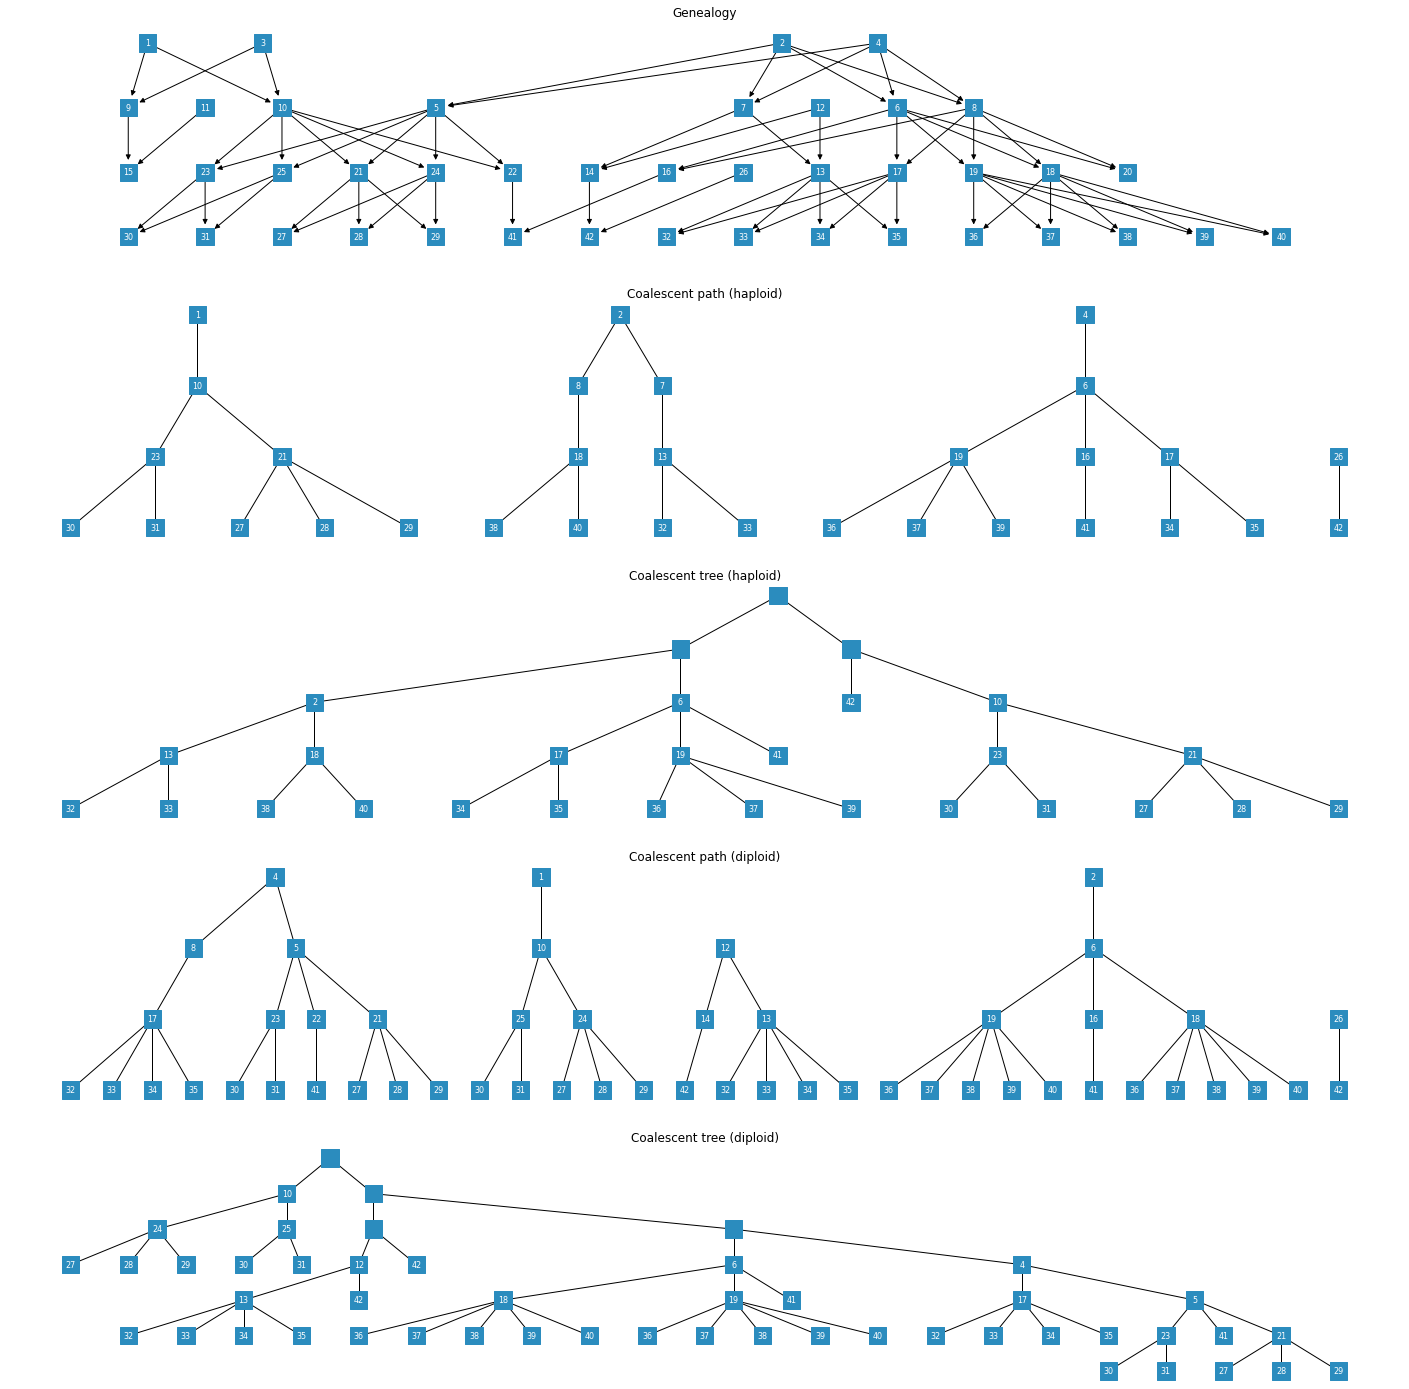

In [2]:
np.random.seed(724)

families = 3
generations = 3
avg_children = 2.2

ped = Pedigree.simulate_from_founders(families, generations, avg_children)

pt_1 = ped.sample_path()
ct_1 = pt_1.to_coalescent_tree()

pt_2 = ped.sample_path(2)
ct_2 = pt_2.to_coalescent_tree()

fig, ax = plt.subplots(nrows=5, figsize=(25, 25))

ped.draw(ax=ax[0])
ax[0].set_title('Genealogy')

pt_1.draw(ax=ax[1], label_dict=pt_1.ts_node_to_ped_node)
ax[1].set_title('Coalescent path (haploid)')
ct_1.draw(ax=ax[2], label_dict=ct_1.ts_node_to_ped_node)
ax[2].set_title('Coalescent tree (haploid)')

pt_2.draw(ax=ax[3], label_dict=pt_2.ts_node_to_ped_node)
ax[3].set_title('Coalescent path (diploid)')
ct_2.draw(ax=ax[4], label_dict=ct_2.ts_node_to_ped_node)
ax[4].set_title('Coalescent tree (diploid)')

{'accuracy': 0.16}


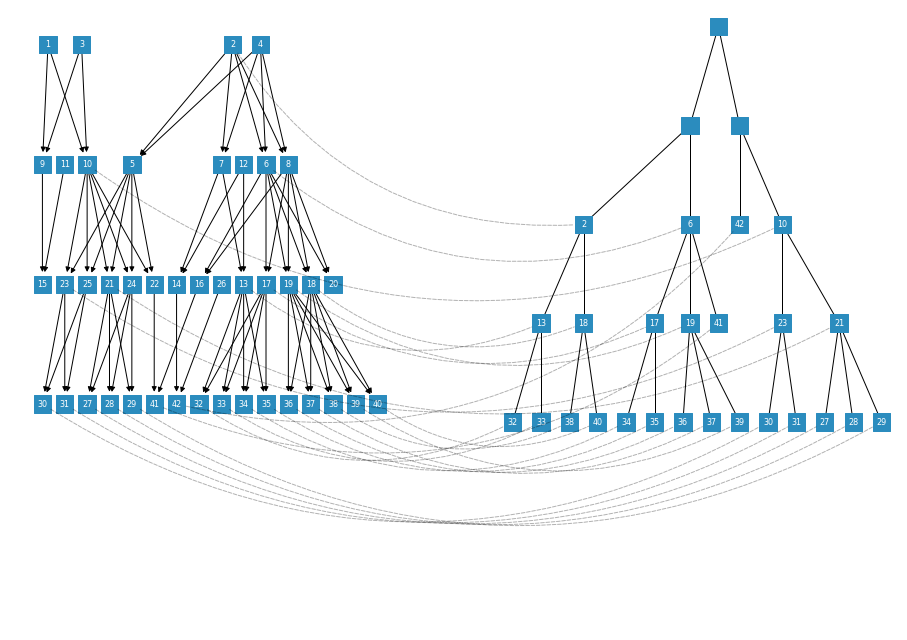

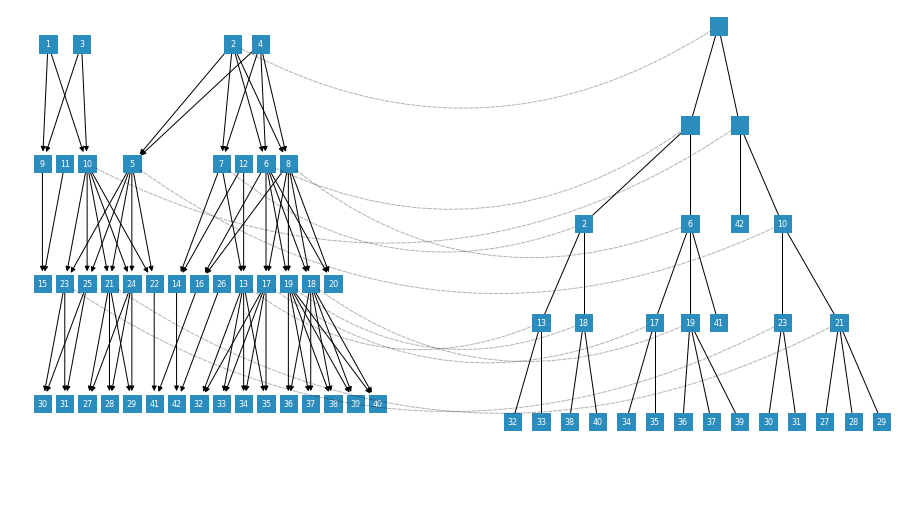

In [8]:
algn = DescMatchingAligner(ped, ct_1)
algn.align()
print(algn.evaluate()) # evaluate accuracy
# draw true vs. predicted
algn.draw()
plt.show()
algn.draw(use_predicted=True)

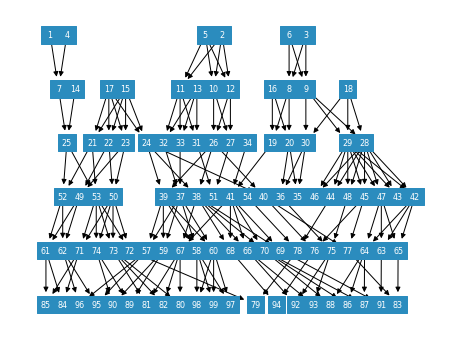

In [10]:
ped = Pedigree.simulate_from_founders(5, 5)

fig, ax = plt.subplots(figsize=(8, 6))

ped.draw(ax=ax)
plt.show()

sim, traversals = ped.generate_msprime_simulations()

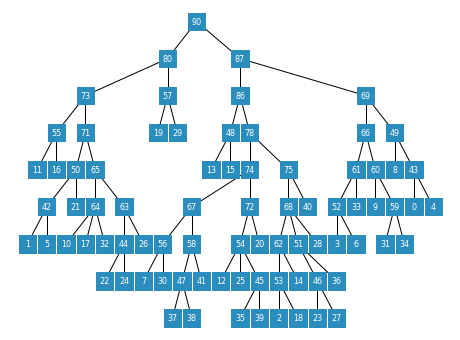

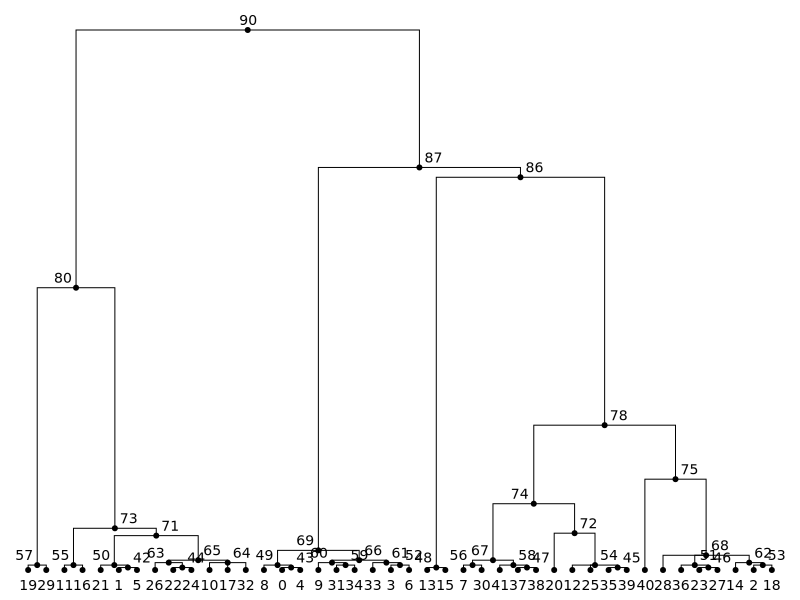

In [11]:
# compare msprime plots to traversal objects:
traversals[0].draw()
plt.show()
display(SVG(sim.first().draw(width=max(800, 2*len(ped.probands())), height=max(600, 2*len(ped.probands())))))

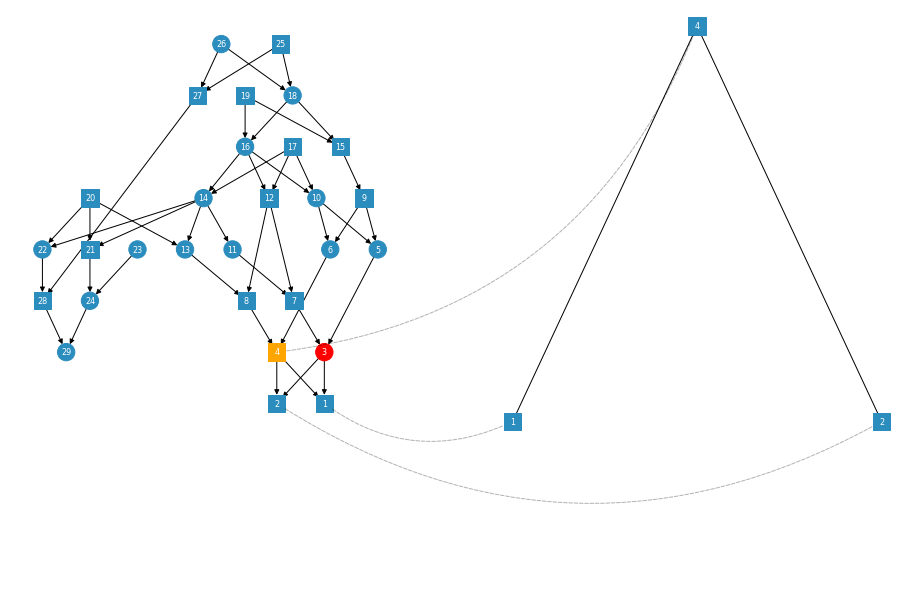

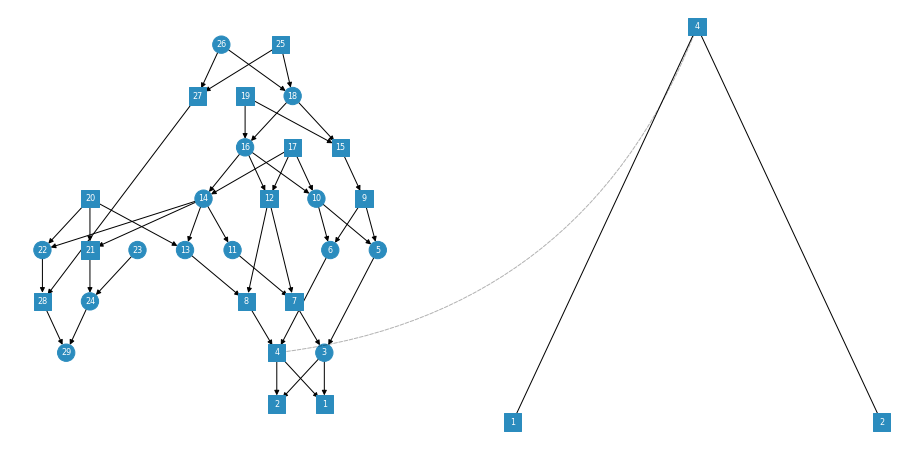

In [15]:
ped = Pedigree.from_table("../data/geneaJi.tsv", header=True, check_2_parents=False)
t = ped.sample_path()
ct = t.to_coalescent_tree()

algn = DescMatchingAligner(ped, ct)
algn.align()
algn.evaluate()

algn.draw(ped_node_color={3: 'red', 4:'orange'})
plt.show()
plt.close()
algn.draw(use_predicted=True)
plt.show()